In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 12})  # Change 14 to your desired font size
from matplotlib.ticker import ScalarFormatter

In [2]:
GpuWriteBackFalseInstance = {1:
(182.36010353635, 7.186374666305577, 173.941035965, 200.536545108),
2:
(192.35853080045, 9.684156893396391, 172.072412449, 213.268668089),
3:
(203.92931455854998, 21.906156800329637, 191.197378462, 278.675921875),
4:
(225.5279676395, 32.64756898417597, 192.48562037, 314.041734809),
6:
(218.66949471529998, 29.286681364875164, 198.756506088, 323.900620577),
12:
(301.59689214495, 35.259248392852356, 262.173418071, 370.442005743),
102:
(1284.1615816840501, 75.10264886201806, 1227.512814871, 1543.026580853),
}

In [3]:
workitems_per_kernel = {1:
76800 * 76800,
2:
38400 * 76800,
3:
25600 * 76800,
4:
19200 * 76800,
6:
12800 * 76800,
12:
6400 * 76800,
102:
753 * 76800
}
print(workitems_per_kernel)

{1: 5898240000, 2: 2949120000, 3: 1966080000, 4: 1474560000, 6: 983040000, 12: 491520000, 102: 57830400}


In [4]:
original = np.array((1041.34356928125, 88.19646874928374, 872.307146568, 1148.751403486))
parralel_part = np.array([
    [10.442990919, 7.303051767, 7.363055198],
    [7.618885348, 7.573912491, 7.554241307],
    [9.597422226, 9.941130937, 10.077726681],
    [22.072701833, 20.172293163000003, 20.23889846600001],
    [59.853311340000005, 65.98120217199998, 65.80573748399996],
    [245.3950390120002, 247.50932743300015, 247.33842502099995]
])
parralel_part_avg = np.mean(parralel_part,axis=1)
total = np.array([48.558,48.733,53.167,64.686,109.699,293.177])
serial_part = total - parralel_part_avg
#P = (original[0] - np.mean(serial_part)) / original[0]

T_o = original[0]
sigma_o = original[1]
T_s = np.mean(serial_part)
sigma_s = np.std(serial_part, ddof=1)

# Compute P
P = (T_o - T_s) / T_o
print(P)

# Derivatives
dP_dTo = T_s / (T_o ** 2)
dP_dTs = -1 / T_o

# Error propagation
dP = np.sqrt((dP_dTo * sigma_o)**2 + (dP_dTs * sigma_s)**2)
print(dP)


0.9582686215152529
0.004258727250320308


In [23]:
def Amdahl(N, P):    
    for n in  N.values():
        print(1-P, n, P/n)
    return [1/((1 - P) + P / n) for n in N.values()]




def Gustafson(N, P):
    return [(1 + (n-1)*P) for n in N.values()]

def Amdahl_error(N, P, dP):
    errors = []
    for n in N.values():
        print(n)
        print(P)
        denom = (1 - P) + P / n
        print(denom)
        dSdP = (1/n - 1) / (denom ** 2)
        errors.append(abs(dSdP) * dP)
    return errors

def Gustafson_error(N, dP):
    return [(n - 1) * dP for n in N.values()]


print(workitems_per_kernel)
A = Amdahl(workitems_per_kernel, P)
print(A)
#A_errors = Amdahl_error(GpuWriteBackFalseInstance, P, dP)

G = Gustafson(workitems_per_kernel, P)
G_errors = Gustafson_error(workitems_per_kernel, dP)


{1: 5898240000, 2: 2949120000, 3: 1966080000, 4: 1474560000, 6: 983040000, 12: 491520000, 102: 57830400}
0.04173137848474706 5898240000 1.6246687512126547e-10
0.04173137848474706 2949120000 3.2493375024253095e-10
0.04173137848474706 1966080000 4.874006253637965e-10
0.04173137848474706 1474560000 6.498675004850619e-10
0.04173137848474706 983040000 9.74801250727593e-10
0.04173137848474706 491520000 1.949602501455186e-09
0.04173137848474706 57830400 1.6570326705595204e-08
[23.9627836993773, 23.96278360608638, 23.962783512795465, 23.96278341950455, 23.96278323292272, 23.962782673177255, 23.962774277741726]


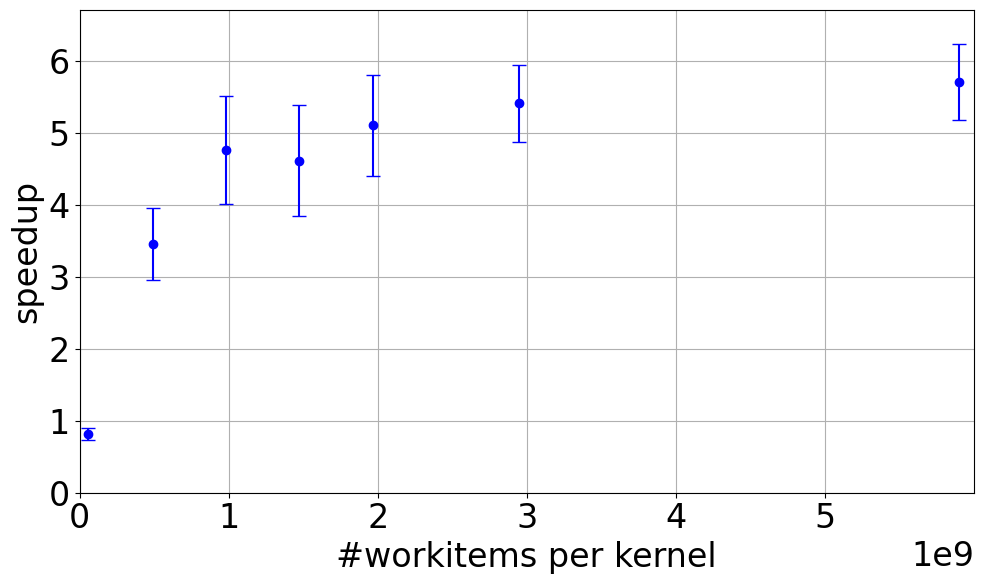

In [19]:
speedup = [original[0]/value[0] for value in GpuWriteBackFalseInstance.values()]
workitems_per_kernel_ = [key for key in workitems_per_kernel.values()]

mean_without = original[0]
mean_with = np.array([value[0] for value in GpuWriteBackFalseInstance.values()])
std_without = original[1]
std_with = np.array([value[1] for value in GpuWriteBackFalseInstance.values()])

speedup_error = speedup * np.sqrt((std_without / mean_without)**2 + (std_with / mean_with)**2)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(workitems_per_kernel_, speedup, color='blue')
ax.errorbar(workitems_per_kernel_, speedup, yerr=speedup_error,  fmt='o', color='blue', ecolor='blue', capsize=5)
plt.xlabel('',fontsize=24)
plt.ylabel('Speedup',fontsize=24)

ax.set_xlabel('#workitems per kernel', fontsize=24)
ax.set_ylabel('speedup', fontsize=24)
ax.tick_params(axis='both', labelsize=24)

fig.canvas.draw()

offset_text = ax.xaxis.get_offset_text()
offset_text.set_size(24)  # Set font size of '1e9'


ax.set_xlim(0, max(workitems_per_kernel_) + 1e8)
ax.set_ylim(0, max(speedup) + 1)

#ax.legend(fontsize=24)
ax.grid(True)
plt.tight_layout()
plt.savefig("graphs/Amdahl's_law__mem_setting__basic_def.svg", format='svg')
plt.show()






0.04173137848474706 5898240000 1.6246687512126547e-10
0.04173137848474706 2949120000 3.2493375024253095e-10
0.04173137848474706 1966080000 4.874006253637965e-10
0.04173137848474706 1474560000 6.498675004850619e-10
0.04173137848474706 983040000 9.74801250727593e-10
0.04173137848474706 491520000 1.949602501455186e-09
0.04173137848474706 57830400 1.6570326705595204e-08
[23.9627836993773, 23.96278360608638, 23.962783512795465, 23.96278341950455, 23.96278323292272, 23.962782673177255, 23.962774277741726]


NameError: name 'x' is not defined

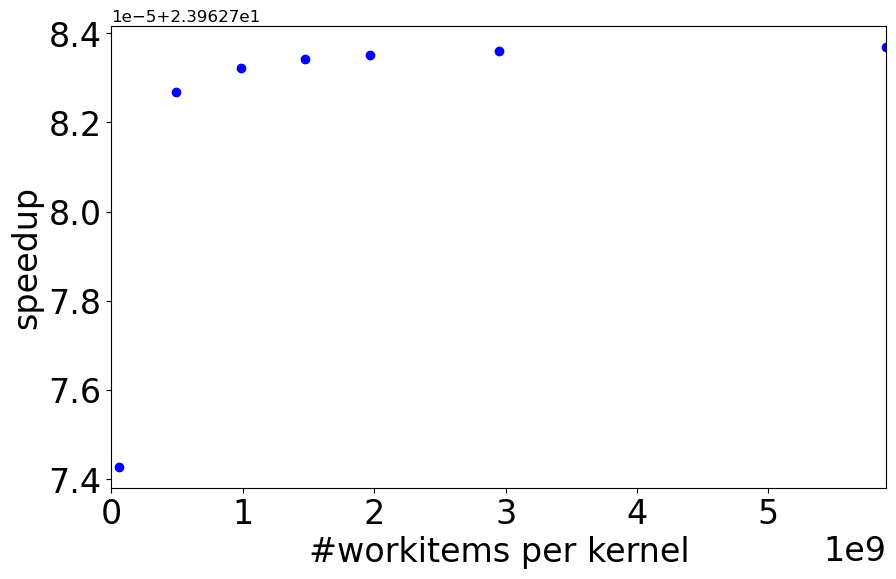

In [21]:
A = Amdahl(workitems_per_kernel, P)
print(A)

#A_errors = Amdahl_error(GpuWriteBackFalseInstance, P, dP)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(workitems_per_kernel_, A, 'o', color='blue')
#ax.errorbar(workitems_per_kernel_, A, yerr=A_errors, fmt='o', color='blue', ecolor='blue', capsize=5)
plt.xlabel('',fontsize=24)
plt.ylabel('Speedup',fontsize=24)

ax.set_xlabel('#workitems per kernel', fontsize=24)
ax.set_ylabel('speedup', fontsize=24)
ax.tick_params(axis='both', labelsize=24)

fig.canvas.draw()

offset_text = ax.xaxis.get_offset_text()
offset_text.set_size(24)  # Set font size of '1e9'


ax.set_xlim(0, max(workitems_per_kernel_) + 1)
x.set_ylim(0, max(A) + 1)

#ax.legend(fontsize=24)
ax.grid(True)
plt.tight_layout()
plt.savefig("graphs/Amdahl's_law__mem_setting__P_def.svg", format='svg')
plt.show()


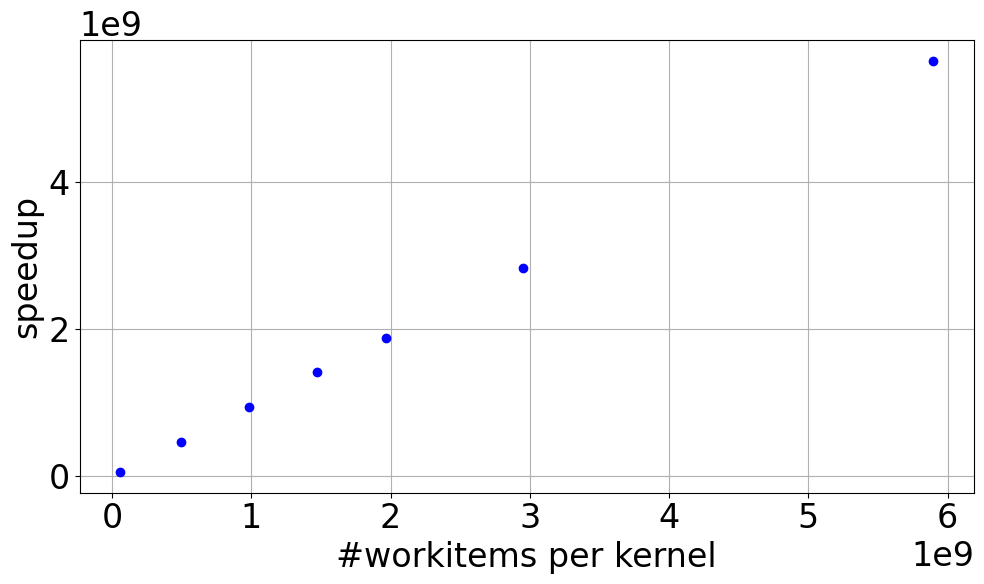

In [25]:
G = Gustafson(workitems_per_kernel, P)
#G_errors = Gustafson_error(GpuWriteBackFalseInstance, dP)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(workitems_per_kernel_, G, 'o', color='blue')
#ax.errorbar(workitems_per_kernel_, G, yerr=G_errors, fmt='o', color='blue', ecolor='blue', capsize=5)
plt.xlabel('',fontsize=24)
plt.ylabel('Speedup',fontsize=24)

ax.set_xlabel('#workitems per kernel', fontsize=24)
ax.set_ylabel('speedup', fontsize=24)
ax.tick_params(axis='both', labelsize=24)

fig.canvas.draw()

offset_text = ax.xaxis.get_offset_text()
offset_text.set_size(24)  # Set font size of '1e9'
offset_text = ax.yaxis.get_offset_text()
offset_text.set_size(24)  # Set font size of '1e9'

#ax.legend(fontsize=24)
ax.grid(True)
plt.tight_layout()
plt.savefig("graphs/Gustafson's_law__mem_setting__P_def.svg", format='svg')
plt.show()
